## Analysis of Fairness

We will now audit the COMPAS algorithm on data collected by ProPublica via the Freedom of Information Act. This dataset comes from pretrial detention hearings in Broward County, Florida, in 2013.

In [2]:
# HIDDEN
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
pd.set_option('display.max_rows', 7)

The variables we would like to examine are: sex/gender, race/ethnicity, age, purpose of assessment (e.g. pretrial release), type of assessment (recidivism, violent recidivism), and the risk-score itself.

In [3]:
defendants = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-raw.csv')

with pd.option_context('display.max_rows', 30):
    print(defendants.loc[[32647, 5032]].drop(['FirstName', 'LastName', 'MiddleName'], axis=1).T)

                                      32647               5032 
Person_ID                             60304               52305
AssessmentID                          69187               58972
Case_ID                               62725               53582
Agency_Text                        PRETRIAL           Probation
Sex_Code_Text                          Male                Male
Ethnic_Code_Text           African-American           Caucasian
DateOfBirth                        07/05/95            05/04/89
ScaleSet_ID                              22                  22
ScaleSet                 Risk and Prescreen  Risk and Prescreen
AssessmentReason                     Intake              Intake
Language                            English             English
LegalStatus                        Pretrial       Post Sentence
CustodyStatus                   Jail Inmate           Probation
MaritalStatus                        Single              Single
Screening_Date                 1/10/14 0

We will restrict ourselves to looking at COMPAS scores for 'Risk of Recidivism':

In [4]:
defendants = defendants[defendants.DisplayText == 'Risk of Recidivism']

The number of defendants screened by COMPAS for Risk of Recidivism is:

In [5]:
len(defendants)

20281

Almost 80% of defendants are classified as male, while the white and Black defendants comprise of approximately 75% of the total population of defendants.

/home/afraenkel/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


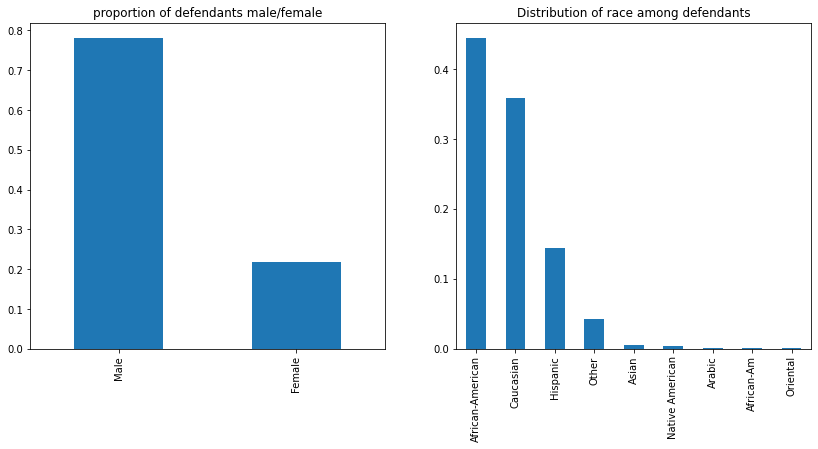

In [6]:
fig, axes = plt.subplots(1,2, figsize=(14,6))

(
    defendants.Sex_Code_Text.value_counts(normalize=True)
    .plot(kind='bar', title='proportion of defendants male/female', ax=axes[0])
)

(
    defendants.Ethnic_Code_Text.value_counts(normalize=True)
    .plot(kind='bar', title='Distribution of race among defendants', ax=axes[1])
);

The majority of uses for the risk assessment are in the pretrial release context. Overall, after the lowest risk score, the recidivism deciles taper off:

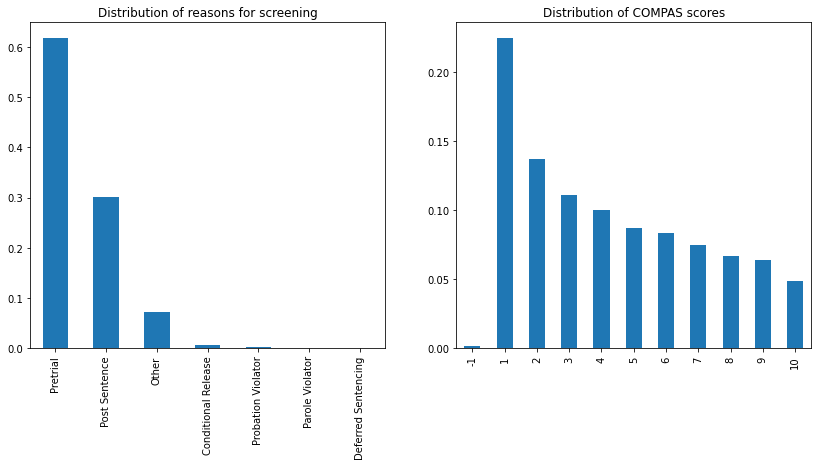

In [7]:
fig, axes = plt.subplots(1,2, figsize=(14,6))

(
    defendants.LegalStatus.value_counts(normalize=True)
    .plot(kind='bar', title='Distribution of reasons for screening', ax=axes[0])
)

(
    defendants.DecileScore.value_counts(normalize=True).sort_index()
    .plot(kind='bar', title='Distribution of COMPAS scores', ax=axes[1])
);

There is a qualitative difference in the distributions among the Black and white defendants.
* White defendants' scores are concentrated at the 'low risk' end of the distribution
* Black defendants' scores are roughly evenly distributed across the deciles

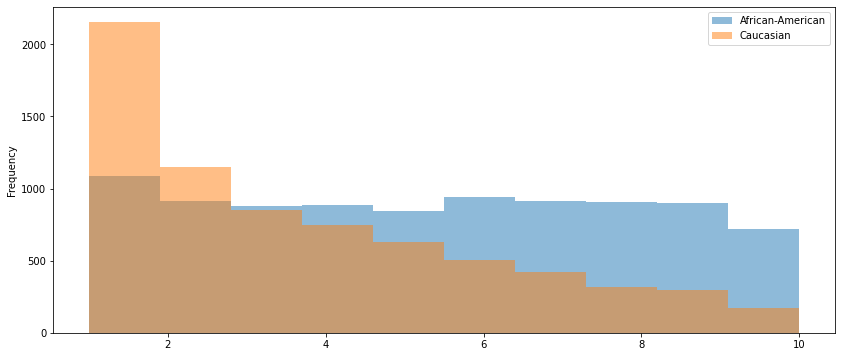

In [8]:
(
    defendants
    .loc[defendants.Ethnic_Code_Text.isin(['African-American', 'Caucasian'])]
    .loc[defendants.DecileScore > 0]
    .groupby('Ethnic_Code_Text')
    .DecileScore
    .plot(kind='hist', alpha=0.5, legend=True, figsize=(14,6))
);

ProPublica also conducted public records research to determine which defendants re-offended in the two years following their COMPAS screening. They were able to follow up on approximately *half* the defendants. See ProPublica's methodology for how this dataset was collected and joined to the one above.

This dataset contains a field `two_year_recid` that is 1 if the defendant re-offended within two years of screening and 0 otherwise. We will concern ourselves with comparing the Black and white populations, as in the article. Similarly, we will consider a COMPAS score of either 'Medium' or 'High' to be a prediction that the defendant will re-offend within two years.

In [9]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
recidivism = (
    pd.read_csv(url)
    [['age_cat', 'sex', 'race', 'decile_score', 'score_text', 'two_year_recid']]
    .loc[lambda x:x.race.isin(['African-American', 'Caucasian'])]
    .assign(COMPAS_Decision=lambda x:x['score_text'].replace({'Low': 0, 'Medium':1, 'High': 1}))
)

The COMPAS algorithm, on the dataset as a whole, is relatively balanced. We list a few observations about the COMPAS algorithms decisions, on average, for the population of study:
* Half the predicted defendants would re-offend (and half predicted not), which is slightly less than the actual proportion of re-offenders.
* 35% of the population experienced an incorrect decision, roughly balanced between false positives and false negatives.

The table below summarizes these statistics:

In [10]:
pd.crosstab(recidivism['COMPAS_Decision'], recidivism['two_year_recid'], normalize=True, margins=True)

two_year_recid,0,1,All
COMPAS_Decision,,,
0,0.346179,0.161463,0.507642
1,0.187642,0.304715,0.492358
All,0.533821,0.466179,1.000000


When looking at the Black and white populations separately, a different picture emerges: 
* a greater proportion of Black defendants experience an incorrect (strict) "will re-offend" prediction than their white counterparts.
* a greater proportion of white defendants experience an incorrect (lenient) "won't re-offend" prediction than their Black counterparts.
* This balance is necessary, as the difference in incorrect prediction types in the overall population is balanced.

In [11]:
b_recid = recidivism[recidivism['race'] == 'African-American']
w_recid = recidivism[recidivism['race'] == 'Caucasian']

pd.concat([
    pd.crosstab(b_recid['COMPAS_Decision'], b_recid['two_year_recid'], normalize=True, margins=True),
    pd.crosstab(w_recid['COMPAS_Decision'], w_recid['two_year_recid'], normalize=True, margins=True)    
], axis=1, keys=['Black', 'White'])

Black                         White                    
two_year_recid          0         1       All         0         1       All
COMPAS_Decision                                                            
0                0.267857  0.143939  0.411797  0.464140  0.187857  0.651997
1                0.217803  0.370400  0.588203  0.142217  0.205786  0.348003
All              0.485660  0.514340  1.000000  0.606357  0.393643  1.000000

However, note that the *true* outcomes of Black and white defendants differ. We should instead consider evaluation metrics that normalize for this difference.

### Accuracy Analysis

First, we will look at the accuracy of the COMPAS predictions (the proportions of predictions that were correct).

In [12]:
print(
    'accuracy (All):  \t %f' % metrics.accuracy_score(recidivism.two_year_recid, recidivism.COMPAS_Decision), 
    'accuracy (Black):\t %f' % metrics.accuracy_score(b_recid.two_year_recid, b_recid.COMPAS_Decision), 
    'accuracy (White):\t %f' % metrics.accuracy_score(w_recid.two_year_recid, w_recid.COMPAS_Decision),
    sep='\n'
)

accuracy (All):  	 0.650894
accuracy (Black):	 0.638258
accuracy (White):	 0.669927


While the COMPAS algorithm performs better on the white population, these accuracies seem fairly close. We can check if this different is significant, using a 5% significance level. (We will use a permutation test to compute the p-value, for visualizing the variation).

The difference in accuracies of the algorithm, between the white and black defendants, is approximately 3%:

In [13]:
obs = (
    recidivism
    .groupby('race')
    .apply(lambda x: metrics.accuracy_score(x.two_year_recid, x.COMPAS_Decision))
    .diff()
    .iloc[-1]
)

obs

0.03166907460917234

Running a permutation test results in a p-value of approximately 1%, which leads us to reject the hypothesis that this difference in accuracies occurred by chance:

0.016


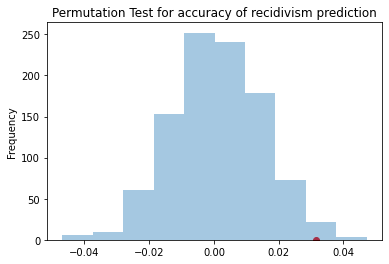

In [14]:
metrs = []
for _ in range(1000):
    s = (
        recidivism
        .assign(race=recidivism.race.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('race')
        .apply(lambda x: metrics.accuracy_score(x.two_year_recid, x.COMPAS_Decision))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)  
    
print(pd.Series(metrs >= obs).mean())
pd.Series(metrs).plot(kind='hist', title='Permutation Test for accuracy of recidivism prediction', alpha=0.4)
plt.scatter(obs, 0, c='r');

On the one hand, this difference *is* significant. On the other hand, the algorithm's quality is still in the same ballpark for both groups. Whether you find this to be a problem, really depends on how strongly you believe egalitarianism to play a role in this discussion. We will read, for example, about theories of *sufficiency* in subsequent weeks, which may assert that any performance over some fixed score (e.g. 60%) is 'good enough'. As of today, there is not consensus in the legal system for how to evaluate such algorithms.

### Other measures of quality

The argument over accuracy, however, is a distraction. Accuracy is *not* the best measure, as false positives and false negatives have *drastically* different meanings. Instead, we should consider these different types of errors separately.
* The False Negative Rate captures the proportion of incorrect "won't re-offend" predictions among all those that actually did re-offend.
* The False Positive Rate captures the proportion of incorrect "will re-offend" predictions among all those that did not actually re-offend.

Using these metrics for evaluation, we observe:
* Among the Black defendants, almost half of all true non-re-offenders were incorrectly labeled to be held in custody.
* Among white defendants, almost half of all true re-offenders were incorrectly labeled low risk, to be released from custody.

Both of these observations, even from the perspective of sufficiency, point to COMPAS failing *both* of these populations in very different ways: Black defendants are disproportionately punished, while white defendants are disproportionately given leniency. The table below summarizes these observations:

In [15]:
def calc_metrics(df):
    
    conf = metrics.confusion_matrix(df.two_year_recid, df.COMPAS_Decision)
    TP = conf[1,1]
    TN = conf[0,0]
    FP = conf[0,1]
    FN = conf[1,0]
    
    fnr = FN / (TP + FN)
    fpr = FP / (FP + TN)
    acc = (TP + TN) / (TP + TN + FP + FN)
    
    return pd.Series({'FNR': fnr, 'FPR': fpr, 'ACC': acc})

pd.concat([
    calc_metrics(recidivism).rename('ALL').to_frame().T,
    recidivism.groupby('race').apply(calc_metrics)
])

,FNR,FPR,ACC
ALL,0.346355,0.351508,0.650894
African-American,0.279853,0.448468,0.638258
Caucasian,0.477226,0.234543,0.669927


### Finishing Remarks

A few finals questions and observations:
* We have not identified *why* the score exhibits this discrepancy!
* Which variables seem to be driving the difference?
    * later we will model the COMPAS scores using LR and Hazard Analysis
* Is COMPAS discriminatory? Legally? In Economic frameworks?
    * Note, race is not present, only correlated variables